In [1]:
import os
import json
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import metrics
import statistics

import matplotlib
%matplotlib inline
import math
from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Concatenate, Flatten, MaxPooling1D
from keras.models import Model
from itertools import islice
from scipy import stats

Using TensorFlow backend.


In [2]:
json_file_dir = "G:\\Dev\\trees_gnps"
gnps_dir = "G:\\Dev\\Data\\GNPS"
fragments_occurences = "G:\\Dev\\fragment_occurences.csv"
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"

In [3]:
fragments_df = pd.read_csv(fragments_occurences, names=["formula", "occurences"])
fragments_df = fragments_df.set_index("formula")

In [4]:
print(fragments_df.index)

Index(['C9H6', 'C8H8', 'C8H6', 'C9H8', 'C10H8', 'C8H8O', 'C7H6', 'C11H8',
       'C7H6O', 'C9H10',
       ...
       'C3H3NS', 'C4H7N3O', 'C5H8ClN5', 'C4H6ClN3', 'CClN', 'C3H2N2',
       'C7H3Cl2NO', 'C3O', 'HO2P', 'C4H11O3PS'],
      dtype='object', name='formula', length=4616)


In [5]:
def read_tree(filepath, fragment_formula):
    fragments = {}
    
    with open(filepath, 'r') as f:
        data = json.load(f)

    for fragment in data['fragments']:
        if fragment['molecularFormula'] in fragment_formula:
            if "intensity" in fragment:
                fragments[(fragment['molecularFormula'])] = float(fragment['intensity'])
     
    return fragments

In [6]:
def dict_is_empty(sample_dict):
    return len(sample_dict.keys()) == 0

def get_mol_names(path_dir):
    return [file[:-3] for file in os.listdir(path_dir)]

def load_tree(path_dir, fragments_formula):
    mol_ids = get_mol_names(path_dir)
    intensities = pd.DataFrame(0.0, index=mol_ids, columns=fragments_formula, dtype=float)
    for file in os.listdir(path_dir):
        mol_name = file[:-3]
        tree_path = json_file_dir + os.sep + mol_name + ".json"
        fragments = read_tree(tree_path, fragments_formula)
        if dict_is_empty(fragments):
            intensities.drop([mol_name], inplace=True)
        else:
            for fragment, intensity in fragments.items():
                intensities.at[mol_name, fragment] = float(intensity)
            if np.amax(intensities.loc[mol_name].values) > 0:
                intensities.loc[mol_name] = intensities.loc[mol_name].div(np.amax(intensities.loc[mol_name].values)).mul(999)
            else:
                intensities.drop([mol_name], inplace=True)
    return intensities


In [7]:
# Loads a master file containing peak intensities for all molecules.
# Each molecule's spectrum is added as a 1000 element row to a Pandas dataframe
# The dataframe is then converted into a numpy array for use as Keras Input.
# Include the option of adding additonal features to each molecule (mass_shifts variable)
def load_master_file(path, mass_shifts = 0, number_of_bins = 1000):
    mol_all = np.loadtxt(path, dtype="U25") # Get master file in as numpy array
    
    mol_ids = np.unique(mol_all[:, 0])  # Trim duplicate filename rows, store unique filenames
    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in mol_ids).
    intensities = pd.DataFrame(0.0, index = mol_ids, columns=range(number_of_bins), dtype=float)
    
    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in mol_all:
        intensities.at[row[0], int(float(row[1]))-1] = float(row[2])
    
    return intensities

# Load a master file containing CDK fingerprints for all molecules.
# Each molecules CDK bit set is added as a 320 element array to a Pandas dataframe.
def load_fingerprints_master(path, number_of_rows=0):
    BITS = 307  # Total number of bits in fingerprint

    fp_all = np.loadtxt(path, dtype="U25", skiprows=number_of_rows) # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0]) # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    fingerprints = pd.DataFrame(0, index = fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        fingerprints.at[row[0], int(row[1])] = int(row[2])

    # Convert populated dataframe into a numpy array for use as output by neural networks.
    return fingerprints

# Load the names of all substructures included in the CDK fingerprint in the correct order
# This is used for boxplots, when performance metrics for individual substructures are calculated.
def load_fingerprint_legend():
    fingerprint_legend = []
    # Open file containing substructure names.
    with open(fingerprints_names_path, 'r') as f:
        # Add each name to the list of substructure names.
        lines = list(islice(f, 0, None))
        for line in lines:
            fingerprint_legend.append(line[:-1])
    return fingerprint_legend


In [8]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
    
def baseline_model(x_train_spectra, x_train_fingerprints):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=x_train_spectra.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(x_train_fingerprints.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return class_model

def comparison_model(x_train_formula, x_train_fingerprints):
    class_model = Sequential()
    class_model.add(Dense(2500, input_dim=x_train_formula.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(1200,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(600,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(x_train_fingerprints.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return class_model

In [9]:
def compute_auc(bits, true, pred):
    # Create structured array to hold statistics for each fingerprint.
    dtype = [('fp_id', int), ('auc', float)]
    mol_stats = np.zeros((bits,), dtype=dtype)
    
    for fp_id in range(true.shape[1]): # For every substructure      
        nonzero_vals = np.count_nonzero(true[:, fp_id]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[:, fp_id].size:  # If there are no 1s or no 0s, can't compute.
            # Compute actual AUC score using only the validation fraction of the dataset.
            fp_true = true[:, fp_id]
            fp_pred = pred[:, fp_id]
            score = metrics.roc_auc_score(fp_true, fp_pred)

            # Update structured array with data or non values if no AUC could be calculated.
            mol_stats[fp_id] = (fp_id, score)
        else:
            mol_stats[fp_id] = (fp_id, 0)
        
    print("Compute AUC done")
    return mol_stats

def compute_f1(bits, true, pred):
    dtype = [('fp_id', int), ('auc', float)]
    mol_stats = np.zeros((bits,), dtype=dtype)
    
    for fp_id in range(true.shape[1]):
        fp_true = true[:, fp_id]
        fp_pred = pred[:, fp_id]
        f1_score = metrics.f1_score(fp_true, fp_pred, average='micro')
        mol_stats[fp_id] = (fp_id, f1_score)
    
    print("Compute F1 score done")
    return mol_stats
    
def compare_aucs(baseline_auc, comparison_auc):
    differences = []
    
    for index, score in enumerate(baseline_auc):
        difference = comparison_auc[index] - baseline_auc[index]
        differences.append(difference)
        
    better = [difference for difference in differences if difference > 0]
    same = [difference for difference in differences if difference == 0]
    worse = [difference for difference in differences if difference < 0]
    
    plt.scatter(range(307), differences)
    plt.title('Tree vs MassIntBin')
    plt.xlabel('Substructures')
    plt.ylabel('AUC Difference')
    plt.show()
    
    return better, same, worse

def calculate_percent_improve(baseline_auc, comparison_auc):
    differences = []
    
    for index, score in enumerate(baseline_auc):
        difference = comparison_auc[index] - baseline_auc[index]
        differences.append(difference)
        
    better = [difference for difference in differences if difference > 0]
    
    return len(better)/len(differences)

In [10]:
def get_training_spec(spectra, fingerprints, train):
    train_spec = spectra[spectra.index.isin(train.index)]
    train_spec.sort_index(inplace=True)
    x_train_spectra = np.log(train_spec.values+1)
    train_fingerprints = fingerprints[fingerprints.index.isin(train_spec.index)]    
    train_fingerprints.sort_index(inplace=True)
    x_train_fingerprints = train_fingerprints.values
    
    return x_train_spectra, x_train_fingerprints

def get_validation_spec(spectra, fingerprints, validate):
    validate_spec = spectra[spectra.index.isin(validate.index)]
    validate_spec.sort_index(inplace=True)
    x_validate_spectra = np.log(validate_spec.values+1)
    validate_fingerprints = fingerprints[fingerprints.index.isin(validate_spec.index)]
    validate_fingerprints.sort_index(inplace=True)
    x_validate_fingerprints = validate_fingerprints.values

    return x_validate_spectra, x_validate_fingerprints

def get_test_spec(spectra, fingerprints, test):
    test_spec = spectra[spectra.index.isin(test.index)]
    test_spec.sort_index(inplace=True)
    x_test_spectra = np.log(test_spec.values+1)
    
    test_fingerprints = fingerprints[fingerprints.index.isin(test_spec.index)]
    test_fingerprints.sort_index(inplace=True)
    x_test_fingerprints = test_fingerprints.values
    
    return x_test_spectra, x_test_fingerprints

def get_training_formula(fingerprints, train):
    x_train_formula = np.log(train.values+1)
    
    train_fingerprints = fingerprints[fingerprints.index.isin(train.index)]
    train_fingerprints.sort_index(inplace=True)
    x_train_fingerprints = train_fingerprints.values
    
    return x_train_formula, x_train_fingerprints

def get_validation_formula(fingerprints, validate):
    x_validate_formula = np.log(validate.values+1)
    
    validate_fingerprints = fingerprints[fingerprints.index.isin(validate.index)]
    validate_fingerprints.sort_index(inplace=True)
    x_validate_fingerprints = validate_fingerprints.values
    
    return x_validate_formula, x_validate_fingerprints

def get_test_formula(fingerprints, test):
    x_test_formula = np.log(test.values+1)
    
    test_fingerprints = fingerprints[fingerprints.index.isin(test.index)]
    test_fingerprints.sort_index(inplace=True)
    x_test_fingerprints = test_fingerprints.values
    
    return x_test_formula, x_test_fingerprints

def run_experiments(spectra, fingerprints, intensities):
    epochs = 100

    train, validate, test = np.split(intensities.sample(frac=1), [int(.6*len(intensities)), int(.8*len(intensities))])

    x_train_spectra, x_train_fingerprints = get_training_spec(spectra, fingerprints, train)
    x_validate_spectra, x_validate_fingerprints = get_validation_spec(spectra, fingerprints, validate)
    x_test_spectra, x_test_fingerprints = get_test_spec(spectra, fingerprints, test)
    
    b_mod = baseline_model(x_train_spectra, x_train_fingerprints)
    history = b_mod.fit(x_train_spectra, x_train_fingerprints, epochs=epochs,validation_data=(x_validate_spectra,x_validate_fingerprints), verbose=0)
    
    b_predicted = b_mod.predict(x_test_spectra)
    base_stats = compute_auc(307, x_test_fingerprints, b_predicted)
    
    # -----------
    
    x_train_formula, x_train_fingerprints = get_training_formula(fingerprints, train)
    x_validate_formula, x_validate_fingerprints = get_validation_formula(fingerprints, validate)
    x_test_formula, x_test_fingerprints = get_test_formula(fingerprints, test)
    
    c_mod = comparison_model(x_train_formula, x_train_fingerprints)
    history = c_mod.fit(x_train_formula, x_train_fingerprints, epochs=epochs, validation_data=(x_validate_formula,x_validate_fingerprints), verbose=0)

    c_predicted = c_mod.predict(x_test_formula)
    comparison_stats = compute_auc(307, x_test_fingerprints, c_predicted)
    
    b_prediction = np.zeros((b_predicted.shape))
    b_prediction[b_predicted > 0.5] = 1
    c_prediction = np.zeros((c_predicted.shape))
    c_prediction[c_predicted > 0.5] = 1
    base_f1_stats = compute_f1(307, x_test_fingerprints, b_prediction)
    comparison_f1_stats = compute_f1(307, x_test_fingerprints, c_prediction)
    
    return base_stats, base_f1_stats, comparison_stats, comparison_f1_stats


In [11]:
spectra_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Data.txt"
fingerprints_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Fingerprints.txt"

In [12]:
intensities = load_tree(gnps_dir, fragments_df.index)
spectra = load_master_file(spectra_path)
spectra = spectra[spectra.index.isin(intensities.index)]
spectra.sort_index(inplace=True)

fingerprints = load_fingerprints_master(fingerprints_path)
fingerprints.sort_index(inplace=True)

In [13]:
experiment_auc_path = "G://Dev//Data//tree_int_binning_experiment_3//"

for i in range(7, 10):
    print(i)
    base_stats, base_f1_stats, comparison_stats, comparison_f1_stats = run_experiments(spectra, fingerprints, intensities)
    base_aucs = [auc[1] for auc in base_stats]
    exp_aucs = [auc[1] for auc in comparison_stats]
    base_f1_scores = [f1[1] for f1 in base_f1_stats]
    exp_f1_scores = [f1[1] for f1 in comparison_f1_stats]
    
    base_exp_aucs_path = experiment_auc_path + "experiment_{}_aucs.csv".format(i)
    f1_scores_path = experiment_auc_path + "f1_scores_int_tree_experiment_{}.csv".format(i)
    
    with open(base_exp_aucs_path, 'w') as f:
        for index, auc in enumerate(base_aucs):
            f.write(str(index) + "," + str(auc) + "," + str(exp_aucs[index]) + "\n")
    
    with open(f1_scores_path, 'w') as f:
        for index, f1 in enumerate(base_f1_scores):
            f.write(str(index) + "," + str(f1) + "," + str(exp_f1_scores[index]) + "\n")

7
Compute AUC done
Compute AUC done
Compute F1 score done
Compute F1 score done
8
Compute AUC done
Compute AUC done
Compute F1 score done
Compute F1 score done
9
Compute AUC done
Compute AUC done
Compute F1 score done
Compute F1 score done


In [35]:
experiment_auc_path = "G://Dev//Data//tree_int_binning_experiment_3//"

auc_filenames = [file[:-4] for file in os.listdir(experiment_auc_path) if file.startswith("experiment")]

fingerprint_base_aucs_df = pd.DataFrame(0.0, index=auc_filenames, columns=range(307), dtype=float)
fingerprint_exp_aucs_df = pd.DataFrame(0.0, index=auc_filenames, columns=range(307), dtype=float)
auc_difference_df = pd.DataFrame(0.0, index=auc_filenames, columns=range(307), dtype=float)

pvalues = []
differences = []
z_differences = []

for file in auc_filenames:
    filepath = os.path.join(experiment_auc_path, file+".csv")
    
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, base_auc, exp_auc = line.split(",")
            fingerprint_base_aucs_df.at[file, int(fingerprint)] = float(base_auc)
            fingerprint_exp_aucs_df.at[file, int(fingerprint)] = float(exp_auc[:-1])
            auc_difference_df.at[file, int(fingerprint)] = float(exp_auc[:-1]) - float(base_auc)

for i in fingerprint_base_aucs_df.columns:
    base_aucs = fingerprint_base_aucs_df[i].tolist()
    exp_aucs = fingerprint_exp_aucs_df[i].tolist()
    base_std = statistics.stdev(base_aucs)
    exp_std = statistics.stdev(exp_aucs)
    difference = [difference for difference in auc_difference_df[i].tolist() if difference != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        z_score = float(abs(difference_mean))/(((base_std**2)+(exp_std**2))**(float(1)/2))
        
    differences.append((i, difference_mean, difference_std))
    z_differences.append((i, z_score))
    t_test = stats.wilcoxon(base_aucs, exp_aucs)
    pvalues.append(t_test.pvalue)

pvalues = [1. if math.isnan(pvalue) else pvalue for pvalue in pvalues]

In [14]:
experiment_auc_path = "G://Dev//Data//tree_int_binning_experiment_3//"

f1_filenames = [file[:-4] for file in os.listdir(experiment_auc_path) if file.startswith("f1")]

fingerprint_base_f1_df = pd.DataFrame(0.0, index=f1_filenames, columns=range(307), dtype=float)
fingerprint_exp_f1_df = pd.DataFrame(0.0, index=f1_filenames, columns=range(307), dtype=float)
f1_difference_df = pd.DataFrame(0.0, index=auc_filenames, columns=range(307), dtype=float)

f1_pvalues = []
f1_differences = []

for file in f1_filenames:
    filepath = os.path.join(experiment_auc_path, file+".csv")
    
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, base_f1, exp_f1 = line.split(",")
            fingerprint_base_f1_df.at[file, int(fingerprint)] = float(base_f1)
            fingerprint_exp_f1_df.at[file, int(fingerprint)] = float(exp_f1[:-1])
            f1_difference_df.at[file, int(fingerprint)] = float(exp_f1[:-1]) - float(base_f1)
                
for i in fingerprint_base_f1_df.columns:
    base_f1s = fingerprint_base_f1_df[i].tolist()
    exp_f1s = fingerprint_exp_f1_df[i].tolist()
    difference = [difference for difference in f1_difference_df[i].tolist() if difference != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        
    f1_differences.append((i, difference_mean, difference_std))
    t_test = stats.wilcoxon(base_f1s, exp_f1s)
    f1_pvalues.append(t_test.pvalue)

f1_pvalues = [1. if math.isnan(pvalue) else pvalue for pvalue in f1_pvalues]

In [15]:
def adjust_pvalues(pvalues):
    pvalues.sort()
    num_tests = len(pvalues)
    new_values = [0.0] * num_tests
    new_values[num_tests-1] = pvalues[num_tests-1]
    
    for i in range(num_tests-1, 0, -1):
        rank = i
        pvalue = pvalues[i]
        previous_adjusted_pvalue = new_values[i]
        adjusted_pvalue = num_tests/rank * pvalue
        new_values[i-1] = min(previous_adjusted_pvalue, adjusted_pvalue)
        
    return new_values


In [36]:
differences.sort(key=lambda x: float(x[1]))
f1_differences.sort(key=lambda x: float(x[1]))
z_differences.sort(key=lambda x: float(x[1]))
differences.reverse()
f1_differences.reverse()
z_differences.reverse()

In [37]:
fingerprint_names = load_fingerprint_legend()

In [38]:
fingerprints = [fingerprint_names[fingerprint[0]] for fingerprint in differences]
f1_fingerprints = [fingerprint_names[fingerprint[0]] for fingerprint in f1_differences]
z_fingerprints = [fingerprint_names[fingerprint[0]] for fingerprint in z_differences]

score_differences = [fingerprint[1] for fingerprint in differences]
f1_score_differences = [f1_score[1] for f1_score in f1_differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]

std_err = [fingerprint[2] for fingerprint in differences]
f1_std_err = [fingerprint[2] for fingerprint in f1_differences]

In [52]:
print([differences.index(difference) for difference in differences if difference[0] == 278])

[54]


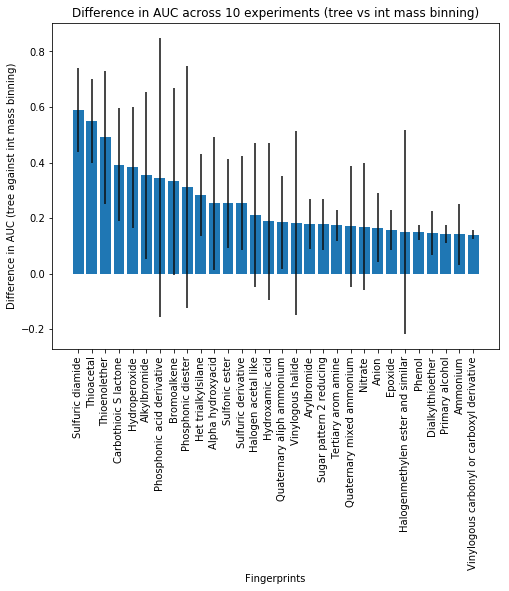

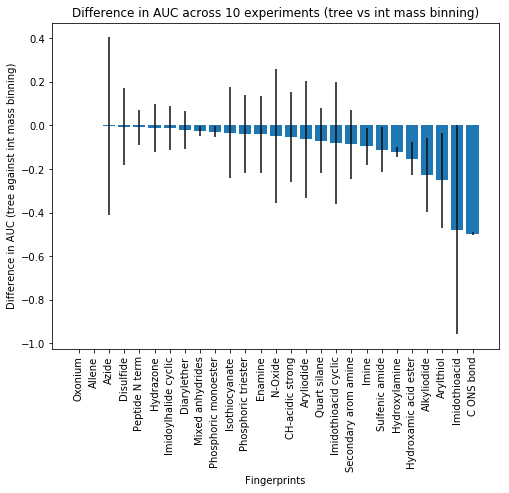

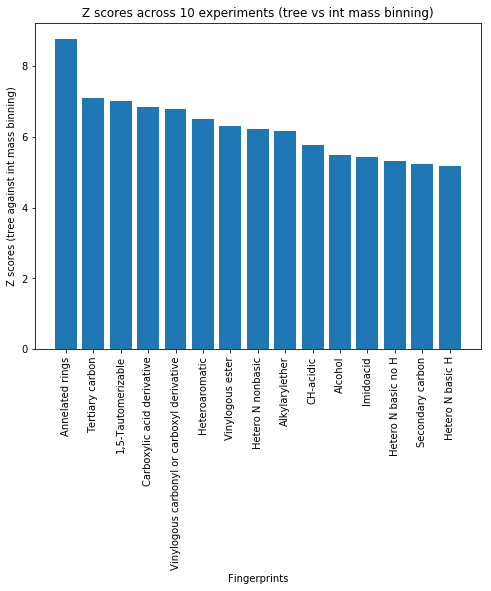

88
150


In [55]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)

plt.title("Difference in AUC across 10 experiments (tree vs int mass binning)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (tree against int mass binning)")
plt.show()

plt.title("Difference in AUC across 10 experiments (tree vs int mass binning)")
plt.bar(fingerprints[280:], score_differences[280:], align='center', yerr=std_err[280:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (tree against int mass binning)")
plt.show()

plt.title("Z scores across 10 experiments (tree vs int mass binning)")
plt.bar(z_fingerprints[:15], z_scores[:15], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (tree against int mass binning)")
plt.show()

adjusted_auc_pvalues = adjust_pvalues(pvalues)
print(len([value for value in adjusted_auc_pvalues if value < 0.05]))
print(len([value for value in adjusted_auc_pvalues if value == 1]))

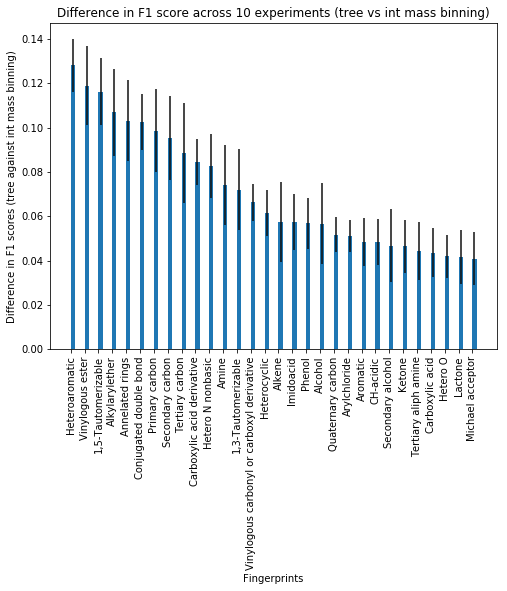

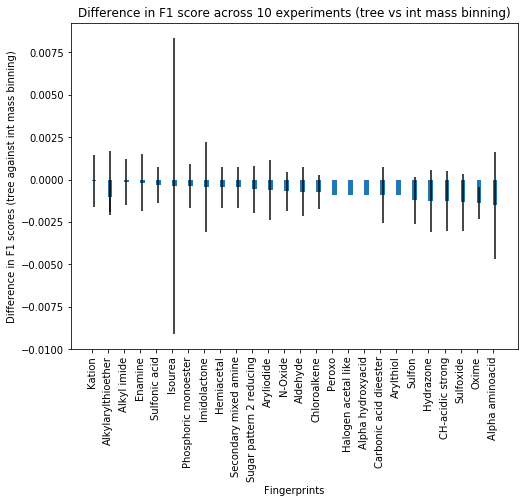

62
168


In [57]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)
plt.title("Difference in F1 score across 10 experiments (tree vs int mass binning)")
plt.bar(f1_fingerprints[:30], f1_score_differences[:30], align='edge', width=0.3, yerr=f1_std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in F1 scores (tree against int mass binning)")
plt.show()

plt.title("Difference in F1 score across 10 experiments (tree vs int mass binning)")
plt.bar(f1_fingerprints[280:], f1_score_differences[280:], align='edge', width=0.3, yerr=f1_std_err[280:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in F1 scores (tree against int mass binning)")
plt.show()

adjusted_f1_pvalues = adjust_pvalues(f1_pvalues)
print(len([value for value in adjusted_f1_pvalues if value < 0.05]))
print(len([value for value in adjusted_f1_pvalues if value == 1]))

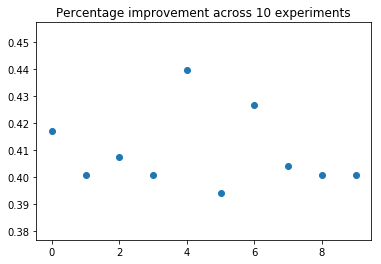

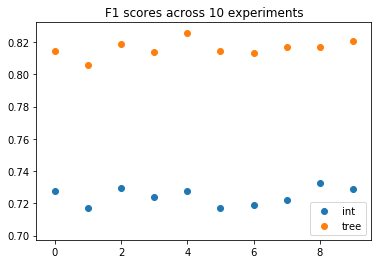

In [26]:
x = np.arange(10)
plt.title("Percentage improvement across 10 experiments")
plt.scatter(x, percent_improve_scores)
plt.show()

plt.title("F1 scores across 10 experiments")
plt.scatter(x, [f1[0] for f1 in f1_scores])
plt.scatter(x, [f1[1] for f1 in f1_scores])
plt.legend(['int', 'tree'])
plt.show()